# The 3 Body problem 

**By:** Juan B. Benavides & Juan P. Vanegas

---

In [1]:
from pathlib import Path

import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from code.rk4.second_order import n_solver
from code.rk4.dat_importer import get_initial
%matplotlib inline

This work aims to be a somewhat detailed study of the 3 body problem solved through different methods. In particular we'll study a Runge-Kutta solution of order 4 and a symplectic method known as PEFRL. 

We'll divide our work in 3 main sections:

1. The 2 Body problem where the 2 methods are compared in a Sun-Earth system and the Runge-Kutta method is shown to be non-conservative while the symplectic method does conserve the energy and the angular momentum of the system.

2. The 3 body problem. Here we include the moon in the previous system and study if this addition is stable in the symplectic method which we have already seen that have a better performance than RK4.

3. Finally we study the Konzai-Lidov mechanism and check what happens to this orbits when the orbit of the moon is not in the same orbital plane as the sun-earth orbit.

In [2]:
from astropy import constants as const
from astropy import units as u


In [3]:
G = const.G.to("AU3 M_earth-1 d-2").value
G

8.88769165499824e-10

In [4]:

def x0j(x0, xj): return x0 - xj

def gravity(x0, xj, mj): return -G*mj*x0j(x0, xj) / \
    np.linalg.norm(x0j(x0, xj))**3

def ode(t, x, v, i, N, dim=3):
    """
    returns acceleration for the i-th body, as a three dimensional array

    a = (ax, ay, az)
    """
    a = np.zeros(dim)
    xi = x[i]

    for j in range(N):
        if j != i:
            a += gravity(xi, x[j], m[j])

    return a


In [5]:
R, m, x0, v0 = get_initial("code/initial/earth_sun.csv", delimiter=',')

In [6]:
TMIN = 0.
TMAX = 10000
N = 1000

t = np.linspace(TMIN, TMAX, N)

x, v = n_solver(ode, TMIN, TMAX, x0, v0, N)

|                    COMPLETE!                      | 100%

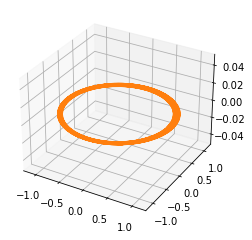

In [7]:
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(x.shape[0]):
    ax.plot(x[i, :, 0], x[i, :, 1], x[i, :, 2])

In [8]:
def potential(x, m, t):
    N = len(x)
    energy = 0.

    for i in range(N):
        x0 = x[i][t]

        for j in range(i+1, N):
            xij = x0 - x[j][t]
            x_norm = np.linalg.norm(xij)
            energy += - G*m[j]/x_norm

    return energy


def total_energy(x, v, m, N, P):
    total_energy = np.zeros(N)

    for i in range(P):
        mi = m[i]
        vi = v[i]

        for t in range(N):
            v2 = np.linalg.norm(vi[t])

            total_energy[t] += 0.5*mi*v2**2


    for t in range(N):
        total_energy[t] += potential(x, m, t)

    return total_energy

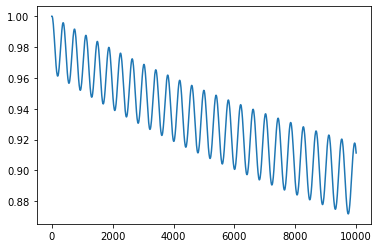

In [9]:
energy = total_energy(x, v, m, N, len(x))

energy /= energy[0]

_ = pl.figure()
_ = pl.plot(t, energy)

pl.show()

In [10]:
def angular_momentum(x, v, m, N, P):
    L = np.zeros(N)

    for i in range(P):
        mi = m[i]
        vi = v[i]
        xi = x[i]

        for t in range(N):
            L[t] = np.linalg.norm(np.cross(xi,mi*vi[t]))


    return L

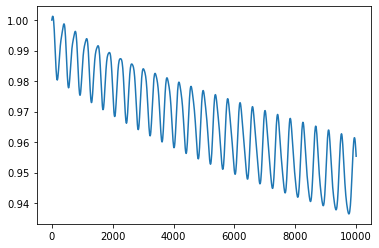

In [11]:
L = angular_momentum(x, v, m, N, len(x))

L /= L[0]

_ = pl.figure()
_ = pl.plot(t, L)

pl.show()

### Change eccentricity

In [12]:
ecc = [0.0167, 0.1, 0.2, 0.5]

In [13]:
x = np.empty(4, object)
v = np.empty(4, object)

for i, e in enumerate(ecc):
    x_0 = x0[:,:]
    x_0[0, 0] += e
    x[i], v[i] = n_solver(ode, TMIN, TMAX, x0, v0, N)

|                                                  | 60%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

|                    COMPLETE!                      | 100%

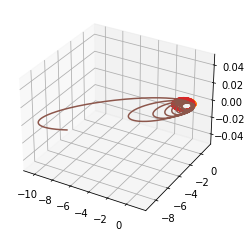

In [37]:
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')

for j in range(x.shape[0]-1):
    for i in range(x[j].shape[0]):
        ax.plot(x[j][i, :, 0], x[j][i, :, 1], x[j][i, :, 2])

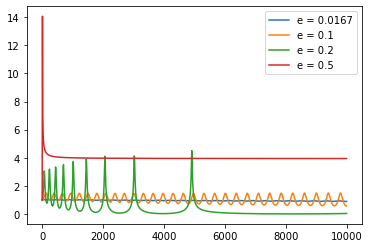

In [15]:
_ = pl.figure()
for i in range(len(x)):
    energy = total_energy(x[i], v[i], m, N, len(x[i]))

    energy /= energy[0]

    _ = pl.plot(t, energy, label=f"e = {ecc[i]}")

_ = pl.legend()

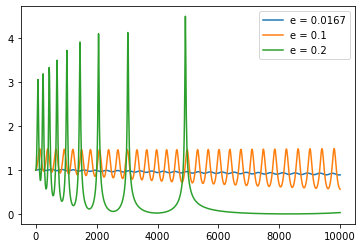

In [16]:
_ = pl.figure()
for i in range(len(x)-1):
    energy = total_energy(x[i], v[i], m, N, len(x[i]))

    energy /= energy[0]

    _ = pl.plot(t, energy, label=f"e = {ecc[i]}")

_ = pl.legend()

## Solutions using PEFRL

In [17]:
path = Path('code/symplectic/first/')

In [18]:
orbits = path / 'orbits'
energy = path/ 'energy'
angular = path/ 'angular'

In [19]:
data_orbits = {}
for i in orbits.iterdir():
    name = str(i).split('/')[-1]
    name = name.split('_')[2]
    data_orbits[name] = np.loadtxt(i, delimiter=',')

data.keys()

NameError: name 'data' is not defined

In [43]:
data_energy= {}
data_angular={}
for i in energy.iterdir():
    name = str(i).split('/')[-1]
    name = name.split('_')[2]
    data_energy[name] = np.loadtxt(i, delimiter=',')

for i in angular.iterdir():
    name = str(i).split('/')[-1]
    name = name.split('_')[2]
    data_angular[name] = np.loadtxt(i, delimiter=',')

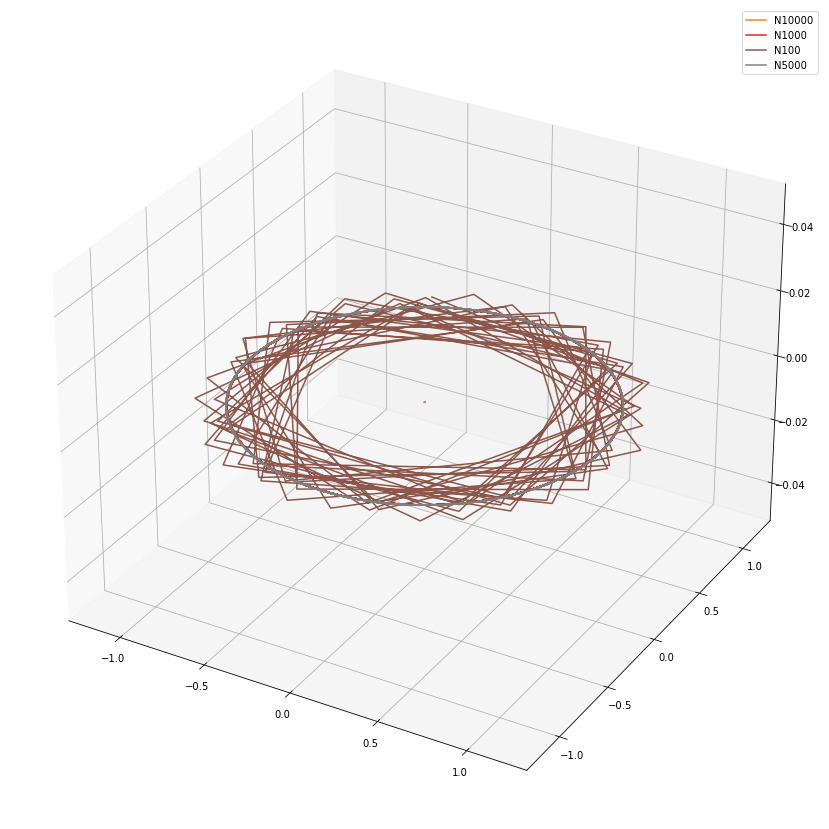

In [50]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
for key in data_orbits.keys():
    if key[0] == 'N':
        dat = data_orbits[key] 
        _ = ax.plot(dat[:, 0], dat[:, 1], dat[:, 2])
        _ = ax.plot(dat[:, 3], dat[:, 4], dat[:, 5], label = key)
_ = pl.legend()

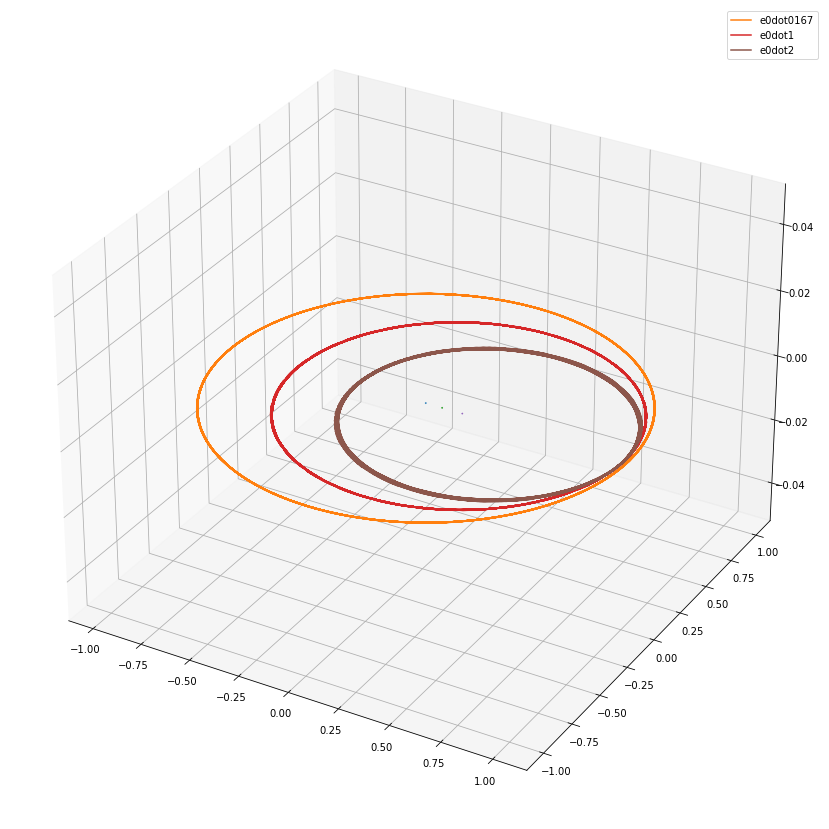

In [51]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
for key in data_orbits.keys():
    if key[0] == 'e' and key[-1] != '5':
        dat = data_orbits[key] 
        _ = ax.plot(dat[:, 0], dat[:, 1], dat[:, 2])
        _ = ax.plot(dat[:, 3], dat[:, 4], dat[:, 5], label = key)
_ = pl.legend()

In [56]:
data_energy['e0dot1'].shape

(1000, 2)

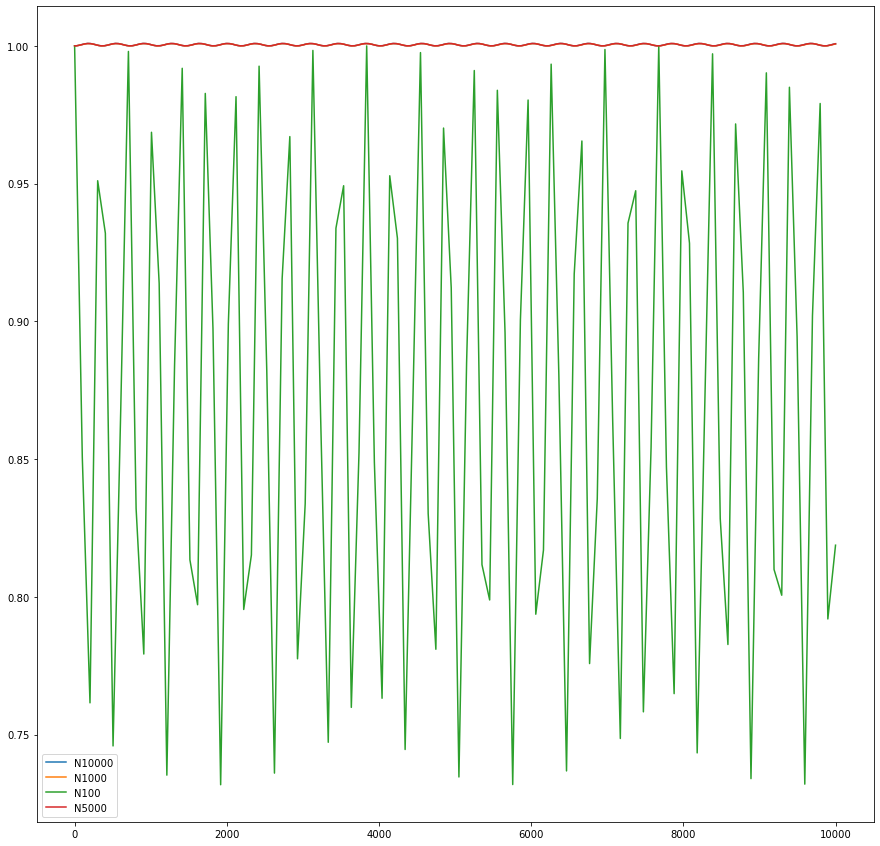

In [59]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for key in data_energy.keys():
    if key[0] == 'N':
        dat = data_energy[key]
        t = dat[:, 0] * (10000/dat[-1, 0]) 
        _ = ax.plot(t, dat[:, 1], label = key)
        
_ = pl.legend()

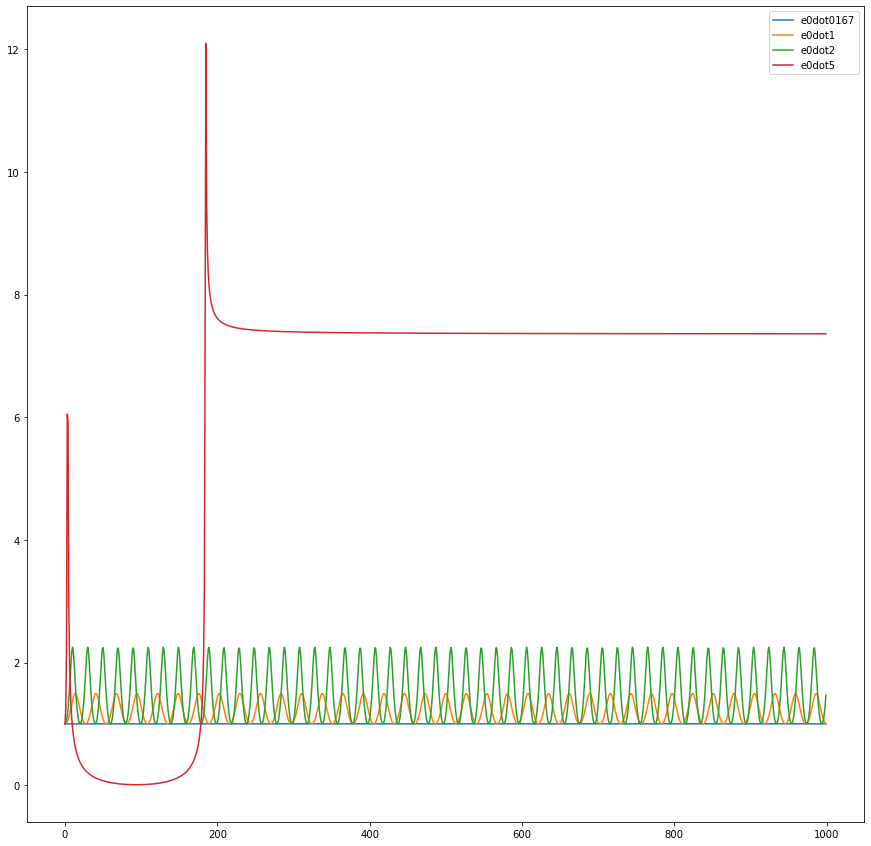

In [60]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for key in data_energy.keys():
    if key[0] == 'e':
        dat = data_energy[key]
        t = dat[:, 0] #* (10000/dat[-1, 0]) 
        _ = ax.plot(t, dat[:, 1], label = key)
        
_ = pl.legend()

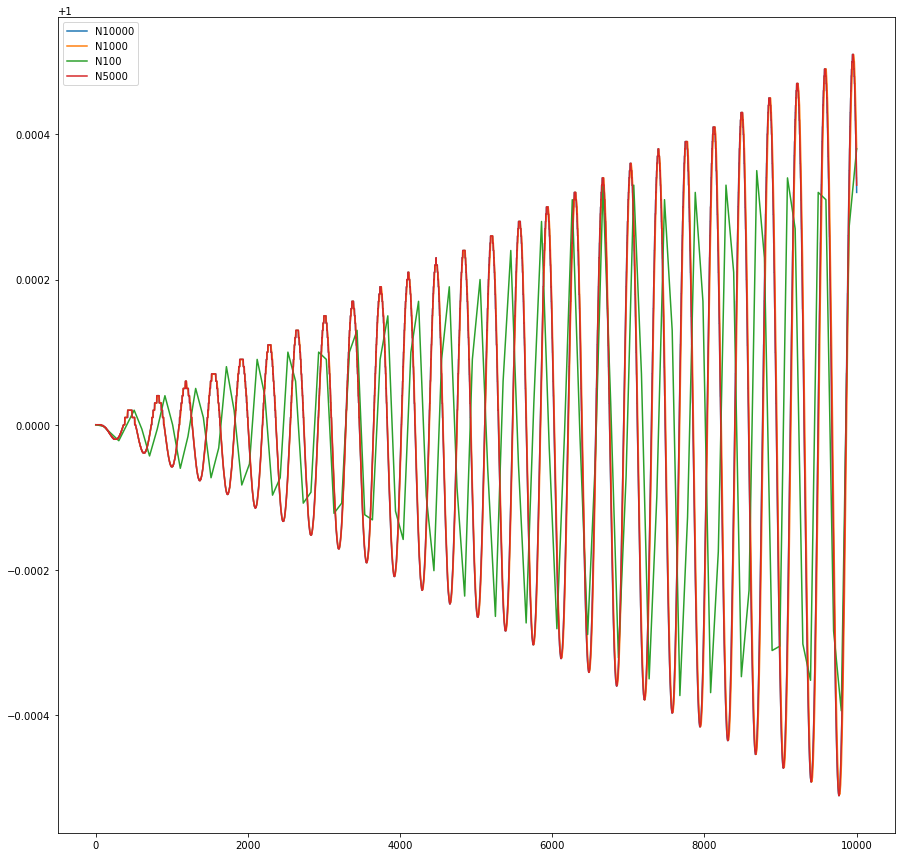

In [66]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for key in data_angular.keys():
    if key[0] == 'N':
        dat = data_angular[key]
        t = dat[:, 0] * (10000/dat[-1, 0]) 
        _ = ax.plot(t, dat[:, 1], label = key)
        
_ = pl.legend()

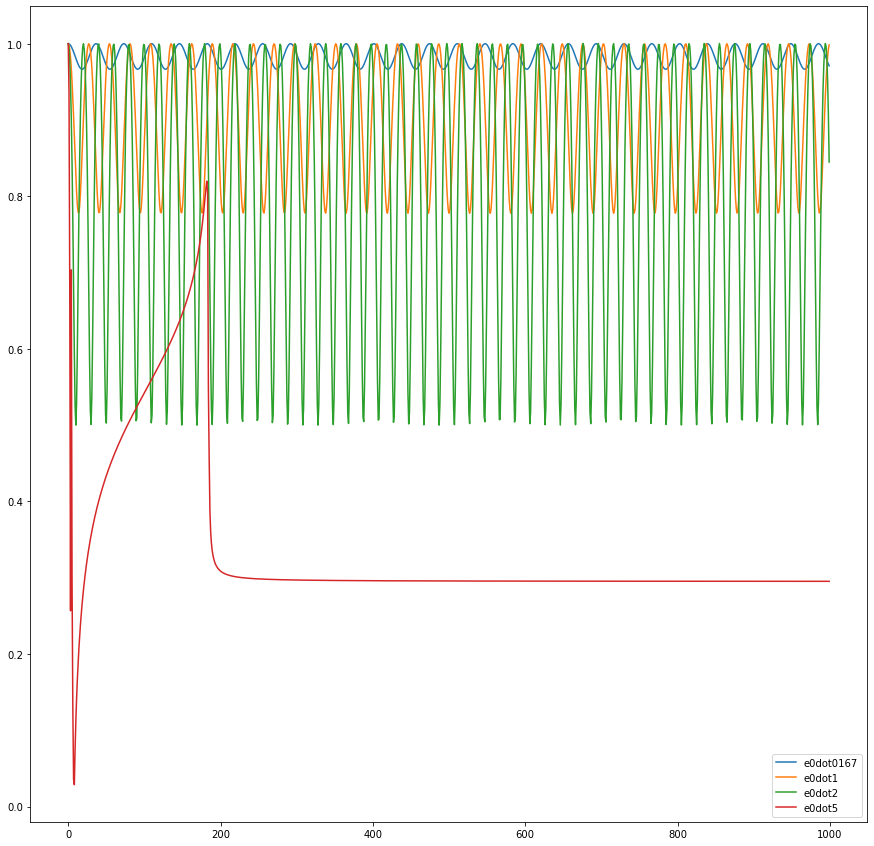

In [62]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for key in data_angular.keys():
    if key[0] == 'e':
        dat = data_angular[key]
        t = dat[:, 0] #* (10000/dat[-1, 0]) 
        _ = ax.plot(t, dat[:, 1], label = key)
        
_ = pl.legend()

## 3 cuerpos

In [38]:
path = Path('code/symplectic/second/')

orbits = path / 'orbits'
energy = path/ 'energy'
angular = path/ 'angular'

In [39]:
data_orbits = {}
data_energy= {}
data_angular={}

for i in orbits.iterdir():
    name = str(i).split('/')[-1]
    name = name.split('_')[2]
    data_orbits[name] = np.loadtxt(i, delimiter=',')
    
for i in energy.iterdir():
    name = str(i).split('/')[-1]
    name = name.split('_')[2]
    data_energy[name] = np.loadtxt(i, delimiter=',')

for i in angular.iterdir():
    name = str(i).split('/')[-1]
    name = name.split('_')[2]
    data_angular[name] = np.loadtxt(i, delimiter=',')

In [71]:
data_orbits['sun'].shape

(1000, 9)

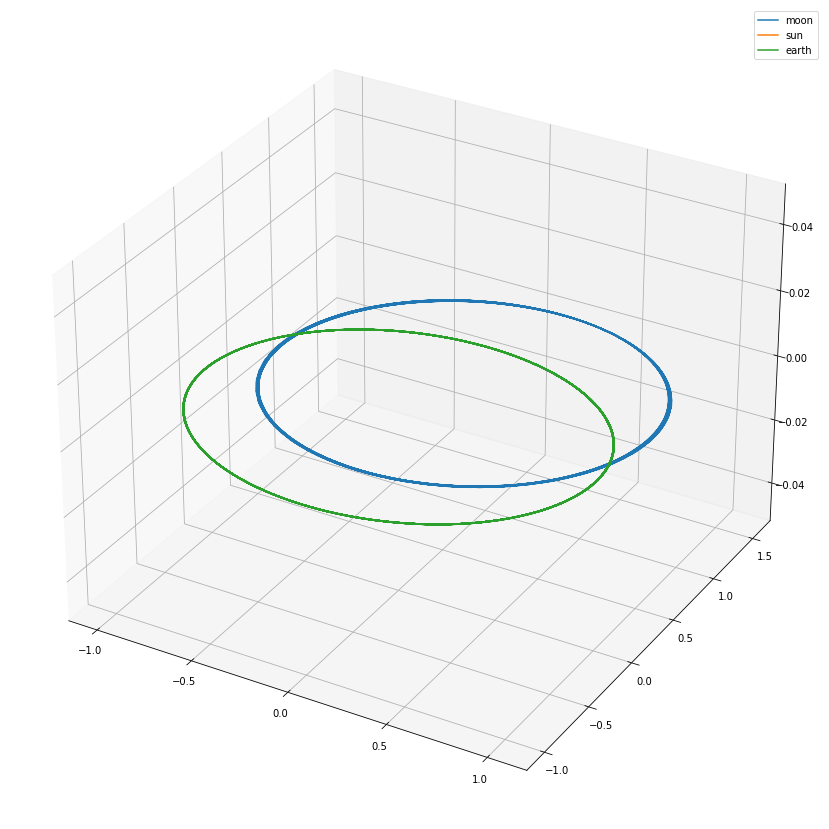

In [40]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
for key in data_orbits.keys():
    dat = data_orbits[key] 
    _ = ax.plot(dat[:, 6], dat[:, 7], dat[:, 8], label = 'moon')
    _ = ax.plot(dat[:, 0], dat[:, 1], dat[:, 2], label = 'sun')
    _ = ax.plot(dat[:, 3], dat[:, 4], dat[:, 5], label = 'earth')
_ = pl.legend()

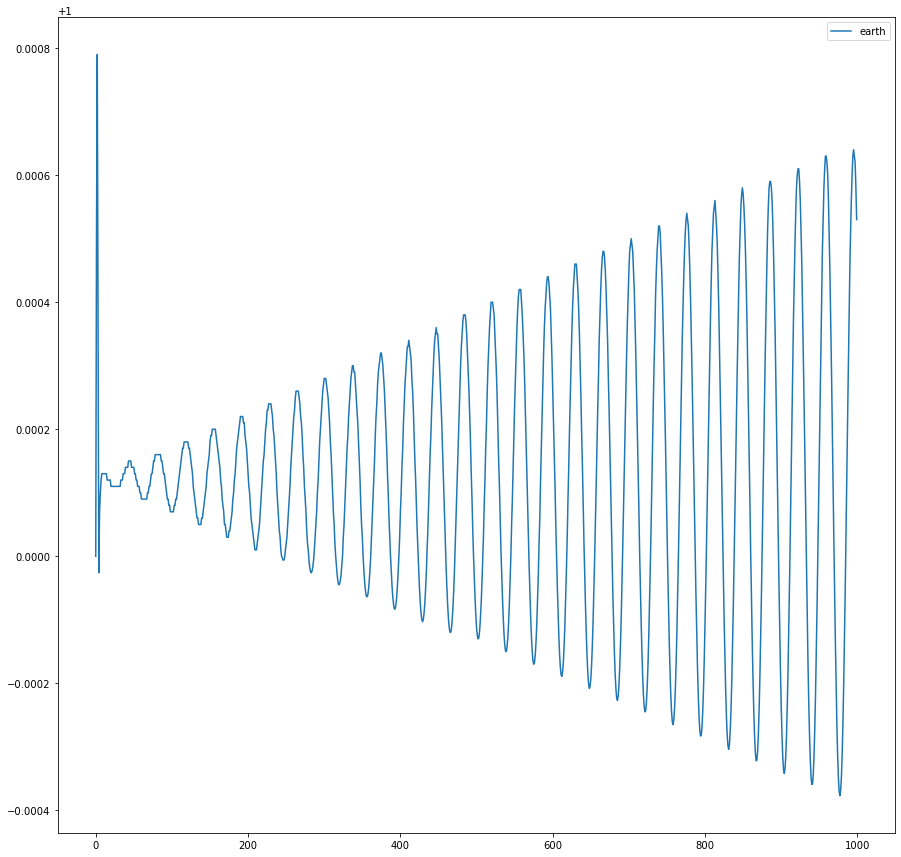

In [27]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for key in data_angular.keys():
    dat = data_angular[key]
    t = dat[:, 0]
    _ = ax.plot(t, dat[:, 1], label = 'earth')
        
_ = pl.legend()

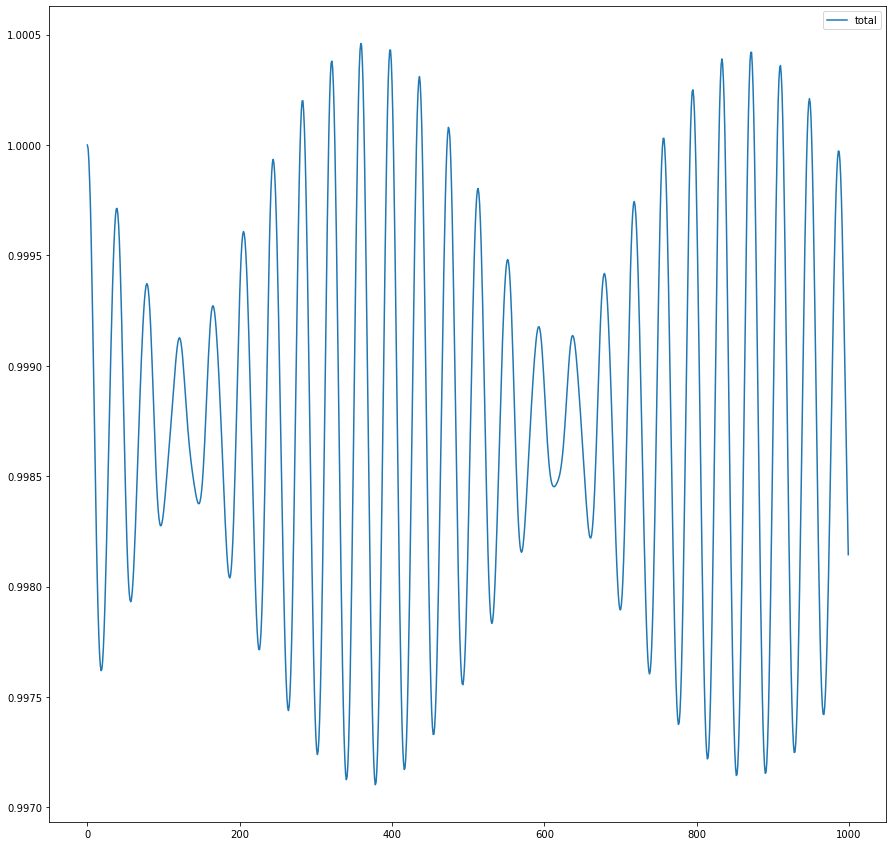

In [26]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for key in data_energy.keys():
    dat = data_energy[key]
    t = dat[:, 0]
    _ = ax.plot(t, dat[:, 1], label = 'total')
        
_ = pl.legend()

## Kozai-Lidov Mechanism

In [28]:
path = Path('code/symplectic/third/')

orbits = path / 'orbits'
energy = path/ 'energy'
angular = path/ 'angular'

In [33]:
data_orbits = {}
data_energy= {}
data_angular={}

for i in orbits.iterdir():
    name = str(i).split('/')[-1]
    name = name.split('_')[1]
    data_orbits[name] = np.loadtxt(i, delimiter=',')
    
for i in energy.iterdir():
    name = str(i).split('/')[-1]
    name = name.split('_')[1]
    data_energy[name] = np.loadtxt(i, delimiter=',')

for i in angular.iterdir():
    name = str(i).split('/')[-1]
    name = name.split('_')[1]
    data_angular[name] = np.loadtxt(i, delimiter=',')

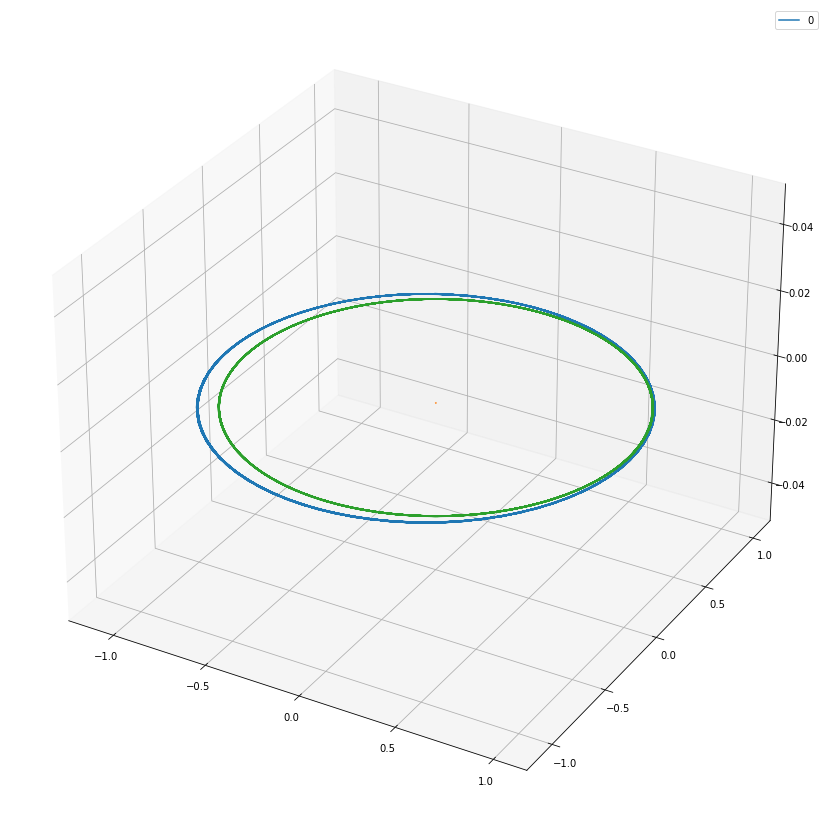

In [36]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
for key in data_orbits.keys():
    if key == '0':
        dat = data_orbits[key] 
        _ = ax.plot(dat[:, 6], dat[:, 7], dat[:, 8], label = key)
        _ = ax.plot(dat[:, 0], dat[:, 1], dat[:, 2])
        _ = ax.plot(dat[:, 3], dat[:, 4], dat[:, 5])
_ = pl.legend()

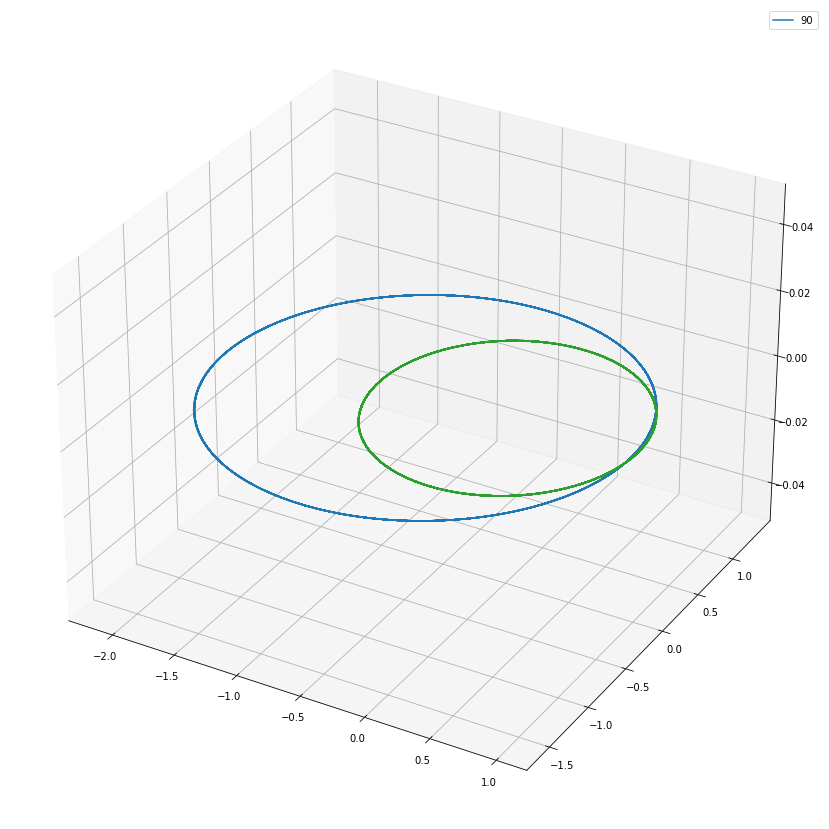

In [37]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
for key in data_orbits.keys():
    if key == '90':
        dat = data_orbits[key] 
        _ = ax.plot(dat[:, 6], dat[:, 7], dat[:, 8], label = key)
        _ = ax.plot(dat[:, 0], dat[:, 1], dat[:, 2])
        _ = ax.plot(dat[:, 3], dat[:, 4], dat[:, 5])
_ = pl.legend()

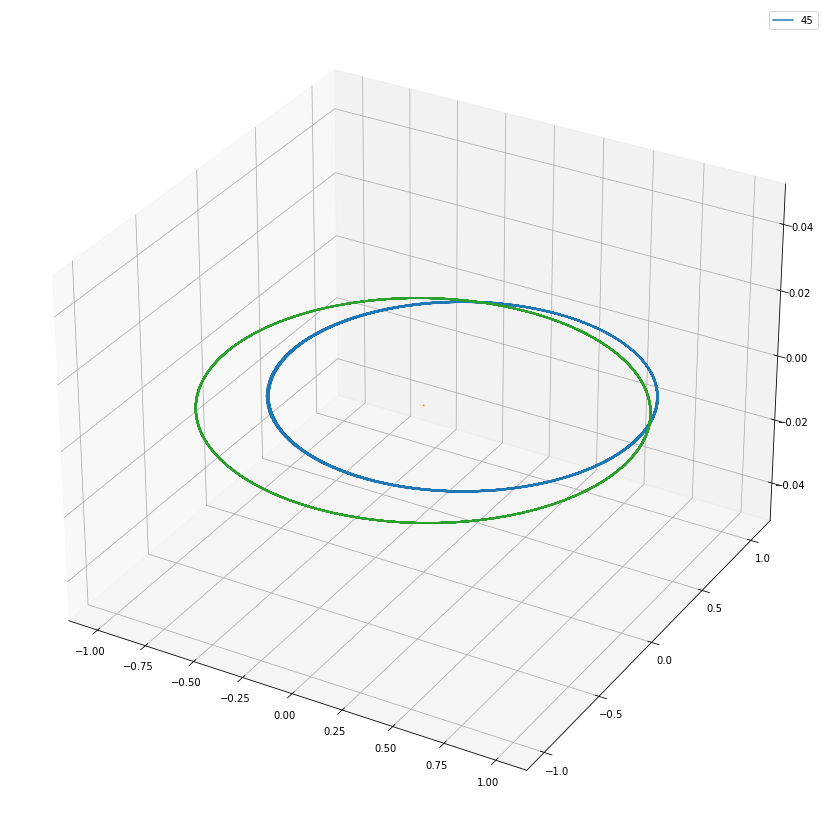

In [38]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
for key in data_orbits.keys():
    if key == '45':
        dat = data_orbits[key] 
        _ = ax.plot(dat[:, 6], dat[:, 7], dat[:, 8], label = key)
        _ = ax.plot(dat[:, 0], dat[:, 1], dat[:, 2])
        _ = ax.plot(dat[:, 3], dat[:, 4], dat[:, 5])
_ = pl.legend()